<a href="https://colab.research.google.com/github/alanfiga/Neural_Networks_USON/blob/main/RNN_CLASE_REDES_NEURONALES_modificaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RNN - LSTM: DOGECOIN**

*Configuración Inicial*

In [1]:
!pip install tensorflow-gpu==2.4.1

     |████████████████████████████████| 394.3MB 40kB/s 


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [4]:
csv_path = 'doge.csv'

In [5]:
df = pd.read_csv(csv_path, index_col="date", parse_dates=['date'])

In [6]:
df = df.sort_values('date')

In [7]:
df.head()

,close
date,
2016-05-12,0.000235
2016-05-13,0.000236
2016-05-14,0.000231
2016-05-15,0.000231
2016-05-16,0.000229


In [6]:
df.shape

(1827, 2)

Text(0.5, 1.0, 'DOGECOIN')

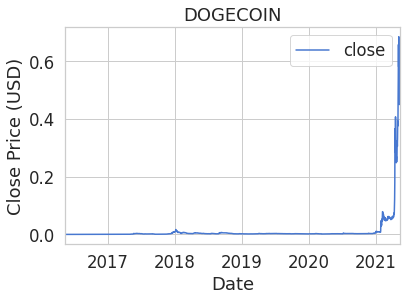

In [7]:
ax = df.plot(x='date', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
ax.set_title("DOGECOIN")

*NORMALIZACIÓN*

In [8]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [9]:
scaled_close.shape

(1827, 1)

In [10]:
np.isnan(scaled_close).any()

False

In [11]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [12]:
scaled_close = scaled_close.reshape(-1, 1)

In [13]:
np.isnan(scaled_close).any()

False

*PREPROCESAMIENTO*

In [14]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [15]:
X_train.shape

(1640, 99, 1)

In [16]:
X_test.shape

(87, 99, 1)

***MODELO 1***

In [18]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))



*ENTRENAMIENTO*

In [65]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 99, 198)           79992     
_________________________________________________________________
dropout (Dropout)            (None, 99, 198)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 99, 396)           628848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 396)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 198)               392832    
_________________________________________________________________
dense (Dense)                (None, 1)                 199       
_________________________________________________________________
activation (Activation)      (None, 1)                

In [20]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)


Epoch 1/50
24/24 [==============================] - 56s 2s/step - loss: 2.2685e-04 - val_loss: 6.5169e-04
Epoch 2/50
24/24 [==============================] - 43s 2s/step - loss: 1.4033e-05 - val_loss: 5.4743e-04
Epoch 3/50
24/24 [==============================] - 44s 2s/step - loss: 3.2765e-05 - val_loss: 5.5749e-04
Epoch 4/50
24/24 [==============================] - 44s 2s/step - loss: 2.7262e-05 - val_loss: 5.7242e-04
Epoch 5/50
24/24 [==============================] - 43s 2s/step - loss: 1.2854e-05 - val_loss: 5.3593e-04
Epoch 6/50
24/24 [==============================] - 44s 2s/step - loss: 1.2026e-05 - val_loss: 4.9530e-04
Epoch 7/50
24/24 [==============================] - 45s 2s/step - loss: 1.5838e-05 - val_loss: 4.8526e-04
Epoch 8/50
24/24 [==============================] - 45s 2s/step - loss: 1.3419e-05 - val_loss: 4.4196e-04
Epoch 9/50
24/24 [==============================] - 43s 2s/step - loss: 1.4783e-05 - val_loss: 4.3613e-04
Epoch 10/50
24/24 [===========================

In [21]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 311ms/step - loss: 0.0349


0.03485806658864021

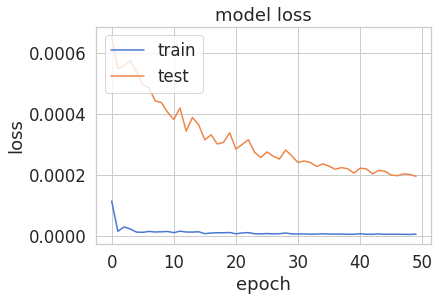

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

*PREDICCIÓN*

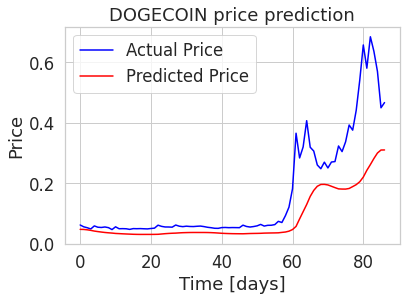

In [24]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('DOGECOIN price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

**MODELO 2**

In [54]:
DROPOUT = 0.15
WINDOW_SIZE = SEQ_LEN - 1

model2 = keras.Sequential()

model2.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model2.add(Dropout(rate=DROPOUT))

model2.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model2.add(Dense(units=1))

model2.add(Activation('linear'))

In [55]:
model2.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 99, 198)           79992     
_________________________________________________________________
dropout_8 (Dropout)          (None, 99, 198)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 198)               236016    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 199       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 316,207
Trainable params: 316,207
Non-trainable params: 0
_________________________________________________________________


In [56]:
BATCH_SIZE = 128

history = model2.fit(
    X_train, 
    y_train, 
    epochs=75, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/75
12/12 [==============================] - 20s 1s/step - loss: 1.6251e-04 - val_loss: 7.0925e-04
Epoch 2/75
12/12 [==============================] - 12s 1s/step - loss: 3.5406e-05 - val_loss: 5.7738e-04
Epoch 3/75
12/12 [==============================] - 12s 997ms/step - loss: 3.0318e-05 - val_loss: 5.3342e-04
Epoch 4/75
12/12 [==============================] - 12s 996ms/step - loss: 2.6946e-05 - val_loss: 5.5545e-04
Epoch 5/75
12/12 [==============================] - 12s 994ms/step - loss: 1.0576e-05 - val_loss: 5.2823e-04
Epoch 6/75
12/12 [==============================] - 12s 1s/step - loss: 1.1867e-05 - val_loss: 4.8776e-04
Epoch 7/75
12/12 [==============================] - 12s 996ms/step - loss: 1.4369e-05 - val_loss: 4.6410e-04
Epoch 8/75
12/12 [==============================] - 12s 989ms/step - loss: 1.4058e-05 - val_loss: 4.4460e-04
Epoch 9/75
12/12 [==============================] - 12s 990ms/step - loss: 1.3263e-05 - val_loss: 4.2446e-04
Epoch 10/75
12/12 [=========

In [57]:
model2.evaluate(X_test, y_test)

3/3 [==============================] - 0s 101ms/step - loss: 0.0126


0.012640077620744705

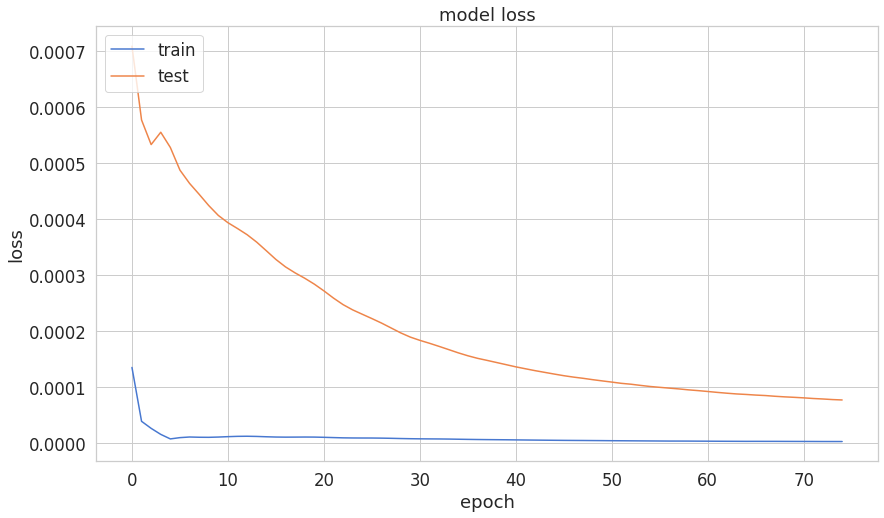

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

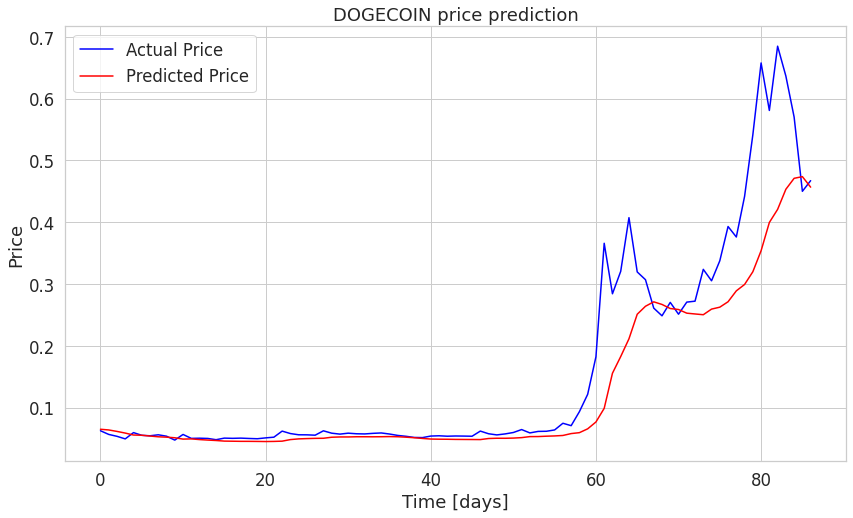

In [59]:
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(model2.predict(X_test))
 
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('DOGECOIN price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();